In [1]:
import torch
import torch.nn as nn
from data_download import load_imdb
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [5]:
print([i2w[w] for w in x_train[141]])

['possibly', 'the', 'best', 'movie', 'ever', 'created', 'in', 'the', 'history', 'of', 'jeffrey', 'combs', 'career', 'and', 'one', 'that', 'should', 'be', 'looked', 'upon', 'by', 'all', 'talent', 'in', 'hollywood', 'for', 'his', 'versatility', 'charisma', 'and', 'uniqueness', 'he', 'brings', 'through', 'his', 'characters', 'and', 'his', 'knowledge', 'of', 'acting']


In [6]:
max_token = max([len(x) for x in x_train]) # Longest review
max_token

2514

In [7]:
batched_x = []
batched_y = []
curr_batch_x = []
curr_batch_y = []
curr_batch_size = 0
for i in reversed(range(len(x_train))):
    curr = x_train[i]
    curr_y = y_train[i]
    if curr_batch_size + len(curr) > max_token: # Adding the current instance to the batch would exceed the max token limit
        batch_max = max([len(x) for x in curr_batch_x])
        curr_batch_x = [instance + [w2i[".pad"]] * (batch_max - len(instance)) for instance in curr_batch_x]
        batched_x.append(curr_batch_x)
        batched_y.append(curr_batch_y)
        curr_batch_x = [curr]
        curr_batch_y = [curr_y]
        curr_batch_size = len(curr)
    elif curr_batch_size + len(curr) == max_token: # Adding the current instance to the batch would exactly match the max token limit
        curr_batch_x.append(curr)
        curr_batch_y.append(curr_y)
        batch_max = max([len(x) for x in curr_batch_x])
        curr_batch_x = [instance + [w2i[".pad"]] * (batch_max - len(instance)) for instance in curr_batch_x]
        batched_x.append(curr_batch_x)
        batched_y.append(curr_batch_y)
        curr_batch_x = []
        curr_batch_y = []
        curr_batch_size = 0
    else: # Adding the current instance to the batch would not exceed the max token limit
        curr_batch_x.append(curr)
        curr_batch_y.append(curr_y)
        curr_batch_size += len(curr)

if curr_batch_x: # If there are any remaining instances in the current batch
    batch_max = max(len(x) for x in curr_batch_x)
    padded_x = [x + [w2i[".pad"]] * (batch_max - len(x)) for x in curr_batch_x]
    batched_x.append(padded_x)
    batched_y.append(curr_batch_y)

In [8]:
for i in range(len(batched_x)):
    print(f"Batch size: {len(batched_x[i])}")
    print(f"Max length of the batch: {max([len(x) for x in batched_x[i]])}")
    print(f"Token per instance: {[len(batched_x[i][x]) for x in range(len(batched_x[i]))]}")

Batch size: 1
Max length of the batch: 2514
Token per instance: [2514]
Batch size: 1
Max length of the batch: 1853
Token per instance: [1853]
Batch size: 1
Max length of the batch: 1773
Token per instance: [1773]
Batch size: 1
Max length of the batch: 1646
Token per instance: [1646]
Batch size: 1
Max length of the batch: 1587
Token per instance: [1587]
Batch size: 1
Max length of the batch: 1568
Token per instance: [1568]
Batch size: 1
Max length of the batch: 1555
Token per instance: [1555]
Batch size: 1
Max length of the batch: 1427
Token per instance: [1427]
Batch size: 1
Max length of the batch: 1422
Token per instance: [1422]
Batch size: 1
Max length of the batch: 1392
Token per instance: [1392]
Batch size: 1
Max length of the batch: 1341
Token per instance: [1341]
Batch size: 1
Max length of the batch: 1316
Token per instance: [1316]
Batch size: 1
Max length of the batch: 1279
Token per instance: [1279]
Batch size: 2
Max length of the batch: 1240
Token per instance: [1240, 1240]


In [9]:
tensor_x = [torch.tensor(batch, dtype=torch.long) for batch in batched_x]
tensor_y = [torch.tensor(batch, dtype=torch.long) for batch in batched_y]

In [59]:
torch.manual_seed(42)

class BaseLineClassifierMax(nn.Module):
    def __init__(self, vocab_size, k):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, k)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(k, 2)
    def forward(self, x): # x size = (batch_size, seq_len)
        x = self.emb(x) # x size = (batch_size, seq_len, k)
        x = x.transpose(1, 2) # x size = (batch_size, k, seq_len)
        x = self.global_pool(x) # x size = (batch_size, k, 1)
        x = x.squeeze(2) # x size = (batch_size, k)
        x = self.fc(x)  # x size = (batch_size, 2)
        return x

In [17]:
def accuracy(pred, y):
    pred = torch.argmax(pred, dim=1)
    correct = (pred == y).float()
    acc = correct.sum() / len(correct)
    return acc
def plot_loss(trainlosses, testlosses=None, labels = None):
    plt.plot(trainlosses, label=labels[0], color='blue')
    if testlosses:
        plt.plot(testlosses, label=labels[1], color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()

In [11]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

device

'cuda'

Model with embedding size 50

In [65]:
torch.manual_seed(42)
model = BaseLineClassifierMax(len(w2i), 50)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
torch.manual_seed(42)
train_losses = []
for epoch in range(10):
    for i, (x, y) in enumerate(zip(tensor_x, tensor_y)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, accuracy: {accuracy(output, y).item() * 100:.2f}%")

Epoch 1, Loss: 0.7079071998596191, accuracy: 47.06%
Epoch 2, Loss: 0.6171125173568726, accuracy: 61.76%
Epoch 3, Loss: 0.5378493666648865, accuracy: 73.53%
Epoch 4, Loss: 0.4888516664505005, accuracy: 76.47%
Epoch 5, Loss: 0.4744488298892975, accuracy: 73.53%
Epoch 6, Loss: 0.5079584717750549, accuracy: 76.47%
Epoch 7, Loss: 0.5290102362632751, accuracy: 76.47%
Epoch 8, Loss: 0.5115153193473816, accuracy: 79.41%
Epoch 9, Loss: 0.4802412688732147, accuracy: 79.41%
Epoch 10, Loss: 0.44603779911994934, accuracy: 79.41%


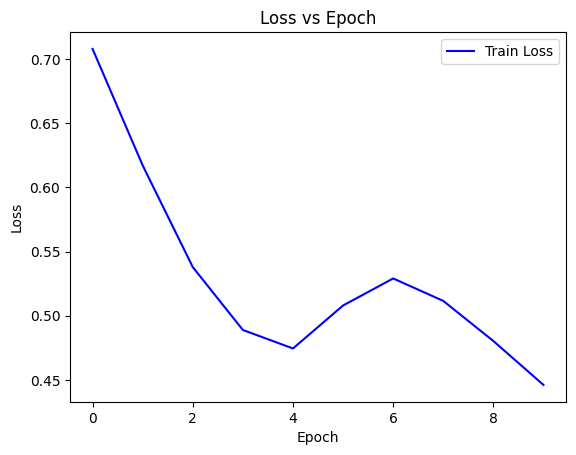

In [67]:
plot_loss(train_losses, labels=['Train Loss'])

Model with embedding size 100

In [68]:
torch.manual_seed(42)
model = BaseLineClassifierMax(len(w2i), 100)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [69]:
torch.manual_seed(42)
train_losses = []
for epoch in range(10):
    for i, (x, y) in enumerate(zip(tensor_x, tensor_y)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, accuracy: {accuracy(output, y).item() * 100:.2f}%")

Epoch 1, Loss: 0.6771780252456665, accuracy: 64.71%
Epoch 2, Loss: 0.57668137550354, accuracy: 79.41%
Epoch 3, Loss: 0.5173041224479675, accuracy: 82.35%
Epoch 4, Loss: 0.43812131881713867, accuracy: 85.29%
Epoch 5, Loss: 0.3672775626182556, accuracy: 88.24%
Epoch 6, Loss: 0.3053646385669708, accuracy: 88.24%
Epoch 7, Loss: 0.25269433856010437, accuracy: 88.24%
Epoch 8, Loss: 0.20420891046524048, accuracy: 91.18%
Epoch 9, Loss: 0.15893526375293732, accuracy: 91.18%
Epoch 10, Loss: 0.11928609013557434, accuracy: 94.12%


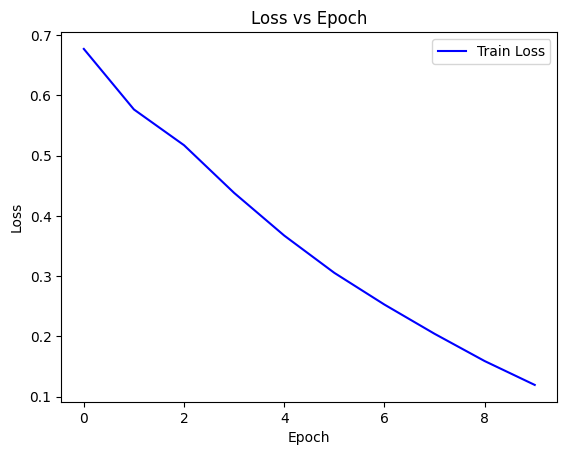

In [70]:
plot_loss(train_losses, labels=['Train Loss'])

Model with embedding size 300, max pooling

In [71]:
model = BaseLineClassifierMax(len(w2i), 300)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
torch.manual_seed(42)
train_losses = []
for epoch in range(10):
    for i, (x, y) in enumerate(zip(tensor_x, tensor_y)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, accuracy: {accuracy(output, y).item() * 100:.2f}%")

Epoch 1, Loss: 0.5769405364990234, accuracy: 76.47%
Epoch 2, Loss: 0.45313337445259094, accuracy: 85.29%
Epoch 3, Loss: 0.38005226850509644, accuracy: 88.24%
Epoch 4, Loss: 0.30879634618759155, accuracy: 88.24%
Epoch 5, Loss: 0.2395928055047989, accuracy: 94.12%
Epoch 6, Loss: 0.17624039947986603, accuracy: 94.12%
Epoch 7, Loss: 0.12217868119478226, accuracy: 97.06%
Epoch 8, Loss: 0.08195678889751434, accuracy: 97.06%
Epoch 9, Loss: 0.04851143807172775, accuracy: 97.06%
Epoch 10, Loss: 0.02533785253763199, accuracy: 100.00%


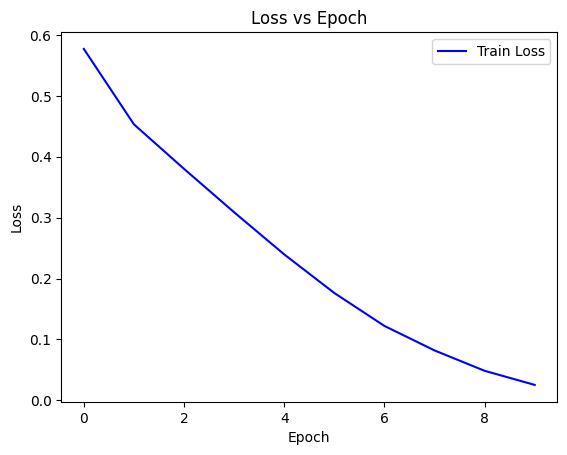

In [73]:
plot_loss(train_losses, labels=['Train Loss'])

Embedding size 100, average pooling

In [78]:
torch.manual_seed(42)

class BaseLineClassifierAvg(nn.Module):
    def __init__(self, vocab_size, k):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, k)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(k, 2)
    def forward(self, x): # x size = (batch_size, seq_len)
        x = self.emb(x) # x size = (batch_size, seq_len, k)
        x = x.transpose(1, 2) # x size = (batch_size, k, seq_len)
        x = self.global_pool(x) # x size = (batch_size, k, 1)
        x = x.squeeze(2) # x size = (batch_size, k)
        x = self.fc(x)  # x size = (batch_size, 2)
        return x

In [79]:
torch.manual_seed(42)
model = BaseLineClassifierAvg(len(w2i), 100)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [80]:
torch.manual_seed(42)
train_losses = []
for epoch in range(10):
    for i, (x, y) in enumerate(zip(tensor_x, tensor_y)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, accuracy: {accuracy(output, y).item() * 100:.2f}%")

Epoch 1, Loss: 4.040269374847412, accuracy: 61.76%
Epoch 2, Loss: 6.623098850250244, accuracy: 67.65%
Epoch 3, Loss: 8.359842300415039, accuracy: 67.65%
Epoch 4, Loss: 9.619010925292969, accuracy: 67.65%
Epoch 5, Loss: 10.44683837890625, accuracy: 67.65%
Epoch 6, Loss: 10.846807479858398, accuracy: 67.65%
Epoch 7, Loss: 10.840810775756836, accuracy: 67.65%
Epoch 8, Loss: 10.485062599182129, accuracy: 70.59%
Epoch 9, Loss: 9.910820960998535, accuracy: 73.53%
Epoch 10, Loss: 9.227298736572266, accuracy: 79.41%


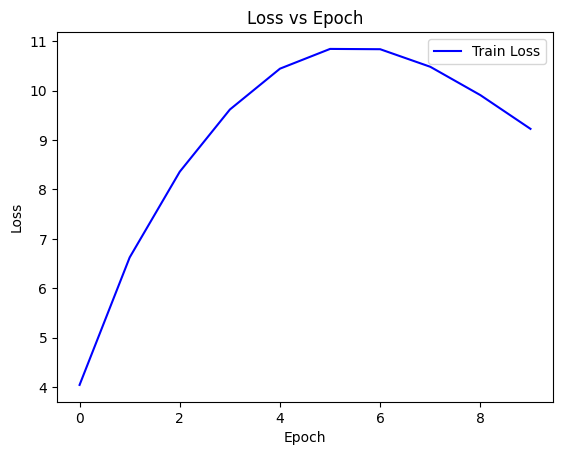

In [81]:
plot_loss(train_losses, labels=['Train Loss'])

In [14]:
torch.manual_seed(42)

class SimpleSelfAttention(nn.Module):
    def __init__(self, vocab_size, k):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, k)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(k, 2)
    def forward(self, x): # x size = (batch_size, seq_len)
        x = self.emb(x) # x size = (batch_size, seq_len, k)
        raw_weights = torch.bmm(x, x.transpose(1, 2))
        weights = F.softmax(raw_weights, dim=2)
        x = torch.bmm(weights, x)
        x = x.transpose(1, 2) # x size = (batch_size, k, seq_len)
        x = self.global_pool(x) # x size = (batch_size, k, 1)
        x = x.squeeze(2) # x size = (batch_size, k)
        x = self.fc(x)  # x size = (batch_size, 2)

        return x

In [15]:
torch.manual_seed(42)
model = (SimpleSelfAttention(len(w2i), 100))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
torch.manual_seed(42)
train_losses = []
for epoch in range(10):
    for i, (x, y) in enumerate(zip(tensor_x, tensor_y)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, accuracy: {accuracy(output, y).item() * 100:.2f}%")

Epoch 1, Loss: 0.574161946773529, accuracy: 79.41%
Epoch 2, Loss: 0.5161937475204468, accuracy: 82.35%
Epoch 3, Loss: 0.43608975410461426, accuracy: 85.29%
Epoch 4, Loss: 0.36296704411506653, accuracy: 88.24%
Epoch 5, Loss: 0.29946914315223694, accuracy: 88.24%
Epoch 6, Loss: 0.24307119846343994, accuracy: 88.24%
Epoch 7, Loss: 0.19399115443229675, accuracy: 91.18%
Epoch 8, Loss: 0.15368962287902832, accuracy: 91.18%
Epoch 9, Loss: 0.11371613293886185, accuracy: 97.06%
Epoch 10, Loss: 0.08337229490280151, accuracy: 97.06%


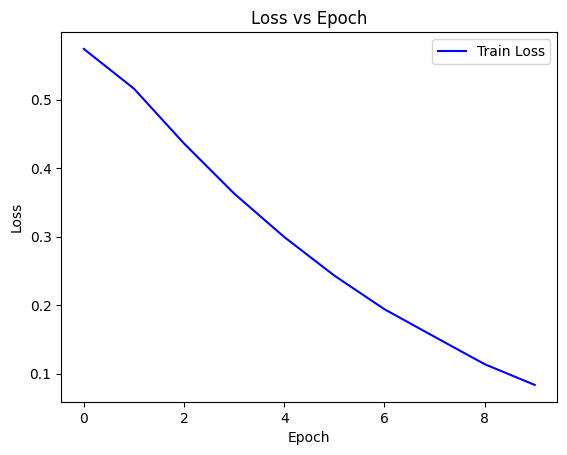

In [19]:
plot_loss(train_losses, labels=['Train Loss'])